In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = coo_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [3]:
import csv

# Write the unique_items list to a CSV file
with open('../data/bgg_id.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[item] for item in unique_items])

In [4]:
import matplotlib.pyplot as plt
# Define the number of components for SVD (adjust based on your application)
n_components = 1000  # This is a hyperparameter; change it to suit your needs

# Initialize and fit TruncatedSVD
svd = TruncatedSVD(n_components=n_components)
svd.fit(sparse_matrix)


TruncatedSVD(n_components=1000)

In [5]:
print(svd.explained_variance_ratio_.sum())

0.6891786964615452


In [6]:
feat = svd.transform(sparse_matrix)
feat = feat / svd.singular_values_[None, :]

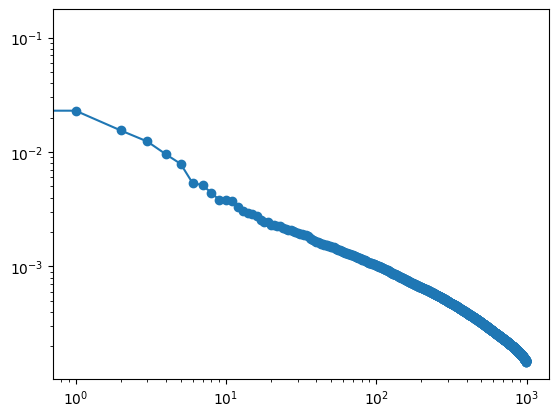

In [7]:
plt.loglog(svd.explained_variance_ratio_, marker='o')
variance = svd.explained_variance_ratio_

In [8]:
import sklearn.metrics
cosine_sim =sklearn.metrics.pairwise.cosine_distances(feat)

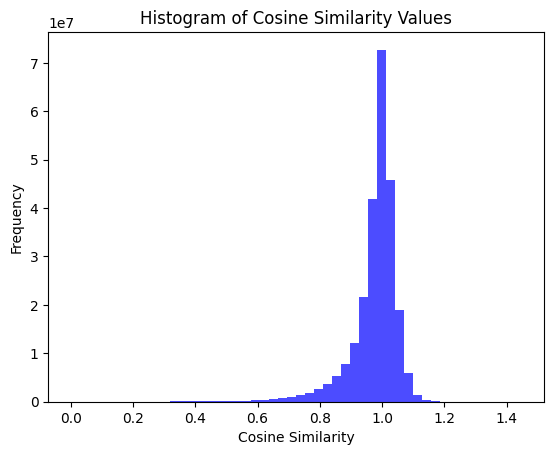

In [9]:
import matplotlib.pyplot as plt

# Flatten the cosine_sim matrix to a 1D array
cosine_values = cosine_sim.flatten()

# Create a histogram
plt.hist(cosine_values, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [10]:
# # Set the diagonal to a high value to exclude it from the minimum search
# np.fill_diagonal(cosine_sim, np.inf)

# # Find the index of the minimum value
# min_index = np.unravel_index(np.argmin(cosine_sim), cosine_sim.shape)

# print("Index of minimum value (excluding diagonal):", min_index)
# unique_items[min_index[0]], unique_items[min_index[1]]
# print("Closest game", unique_items[min_index[0]], unique_items[min_index[1]])
# print("Distance", cosine_sim[min_index])
# # Set the diagonal to 0
# np.fill_diagonal(cosine_sim, 0)

In [11]:
# # You need to install HDBSCAN first: pip install hdbscan
# import hdbscan

# # Example with a minimum cluster size parameter
# hdb = hdbscan.HDBSCAN()
# clusters = hdb.fit_predict(feat)

In [12]:
from sklearn.cluster import KMeans
k = 10  # Set the number of clusters; you can use techniques like the elbow method to choose k
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(feat)

In [13]:
# #2M
# from sklearn.cluster import AffinityPropagation
# k = 10  # Set the number of clusters; you can use techniques like the elbow method to choose k
# aff = AffinityPropagation(random_state=42,verbose=True)
# clusters = aff.fit_predict(sparse_matrix)

In [14]:
# #5M
# from sklearn.cluster import Birch
# k = 10  # Set the number of clusters; you can use techniques like the elbow method to choose k
# bir = Birch()
# clusters = bir.fit_predict(cosine_sim)

In [15]:
# from sklearn.cluster import AgglomerativeClustering


# model = AgglomerativeClustering(
#     linkage='complete',       # recommended with cosine distances
#     n_clusters=2        # set your desired number of clusters
# )
# clusters = model.fit_predict(feat)

In [16]:
# #too much time
# from sklearn.mixture import GaussianMixture
# k = 3  # Set the number of clusters; you can use techniques like the elbow method to choose k
# gau = GaussianMixture(verbose=20, n_components=k,max_iter=10)
# clusters = gau.fit_predict(cosine_sim)

In [17]:
# from sklearn.cluster import DBSCAN

# # Adjust eps (the neighborhood radius) and min_samples (minimum neighbors to form a dense region) as needed
# dbscan = DBSCAN(eps=1000, min_samples=5)
# clusters = dbscan.fit_predict(sparse_matrix)

In [21]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
# Convert cosine distance to similarity



range_n_clusters = [64,128]

for n_clusters in range_n_clusters:
    model = SpectralClustering(n_clusters=n_clusters)
    clusters = model.fit_predict(feat)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(feat, clusters)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 64 The average silhouette_score is : -0.33144323526672537
For n_clusters = 128 The average silhouette_score is : -0.3352595142579045


In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# Suppose D is your cosine distance matrix (a square numpy array)
mds = MDS(verbose=20, random_state=42,max_iter=10)
latent_2d = mds.fit_transform(feat)

In [32]:
import umap.umap_ as UMAP
import matplotlib.pyplot as plt

umapResult = UMAP.UMAP(n_components=2)
latent_2d = umapResult.fit_transform(feat)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{np.int32(0): np.int64(1230), np.int32(1): np.int64(49), np.int32(2): np.int64(9503), np.int32(3): np.int64(436), np.int32(4): np.int64(579), np.int32(5): np.int64(736), np.int32(6): np.int64(415), np.int32(7): np.int64(447), np.int32(8): np.int64(361), np.int32(9): np.int64(1982)}


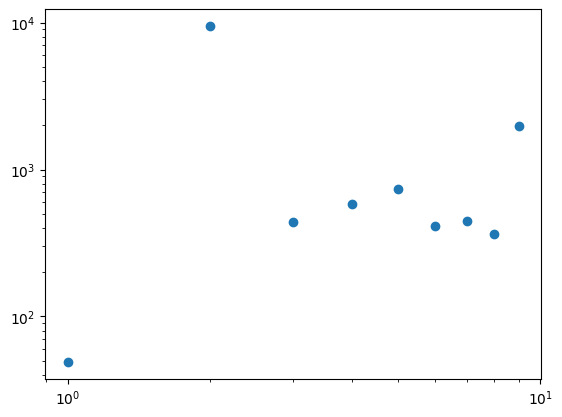

In [37]:
unique_clusters, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
print(cluster_counts)
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')

In [39]:
indices = np.where(clusters == 1)[0]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.to_string())

1492    Escape Room: The Game
1815    Exit: The Game – The Forbidden Castle
1589    Exit: The Game – The Forgotten Island
1632    Exit: The Game – The Polar Station
2582    Deckscape: Test Time
1385    Exit: The Game – The Sunken Treasure
2574    Exit: The Game – The House of Riddles
1347    Exit: The Game – The Sinister Mansion
562    Exit: The Game – Dead Man on the Orient Express
4283    Deckscape: The Fate of London
1542    Exit: The Game – The Mysterious Museum
2765    Deckscape: Heist in Venice
3830    Sherlock: The Tomb of the Archaeologist
4917    Sherlock: Death on the 4th of July
3316    Sherlock: Last Call
1671    Escape Tales: The Awakening
106887    Unlock!: Exotic Adventures
1659    Exit: The Game – The Catacombs of Horror
3807    Deckscape: The Mystery of Eldorado
674    Unlock!: Heroic Adventures
3177    Deckscape: Behind the Curtain
1847    Adventure Games: The Dungeon
3203    Adventure Games: Monochrome Inc.
1919    Exit: The Game – The Haunted Roller Coaster
771    U

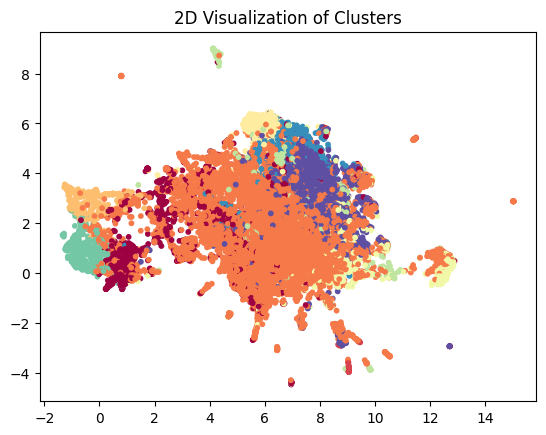

In [38]:
import umap.umap_ as UMAP
import matplotlib.pyplot as plt

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap='Spectral', s=10)
plt.title("2D Visualization of Clusters")
plt.show()